# Advanced Lane Finding

## Udacity Self Driving Car Engineer Nanodegree - Project 4

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

### Step 1: Distortion Correction

#### 1. Finding Corners
The first step in the project is to remove any distortion from the images by calculating the camera calibration matrix and distortion coefficients using a series of images of a chessboard.

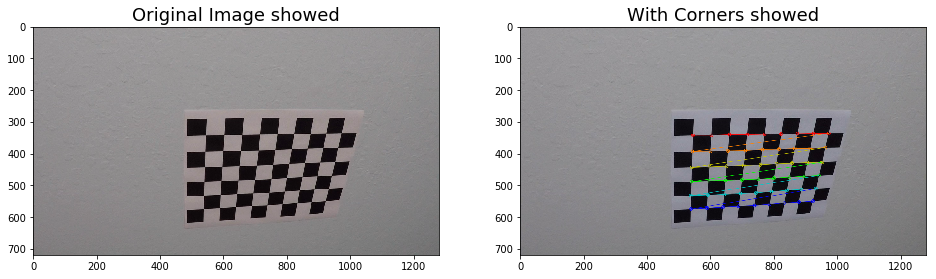

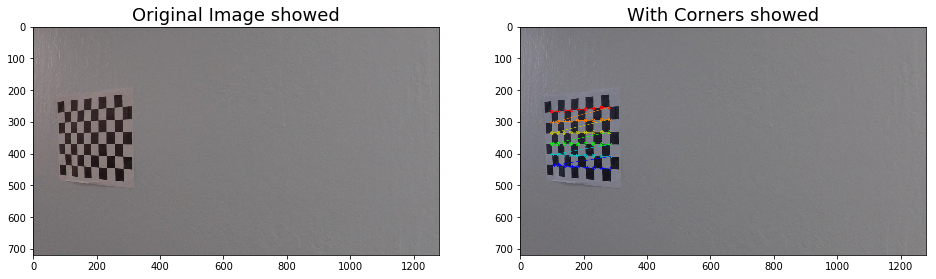

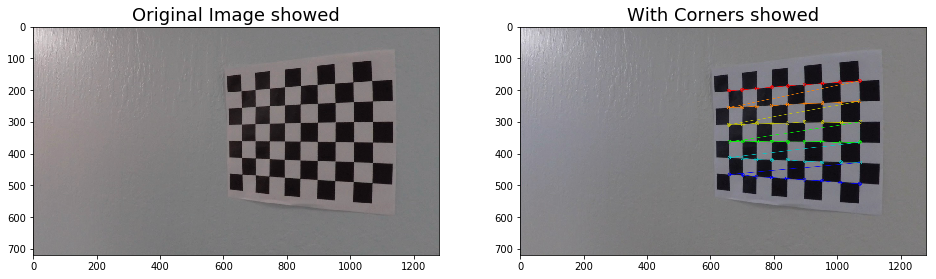

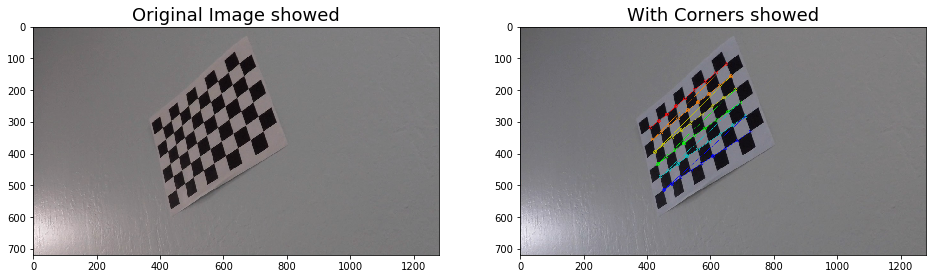

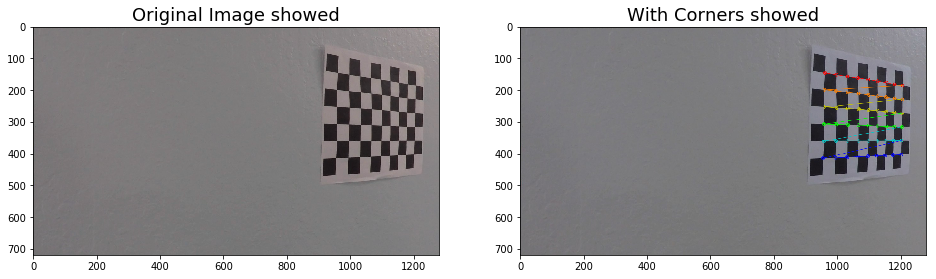

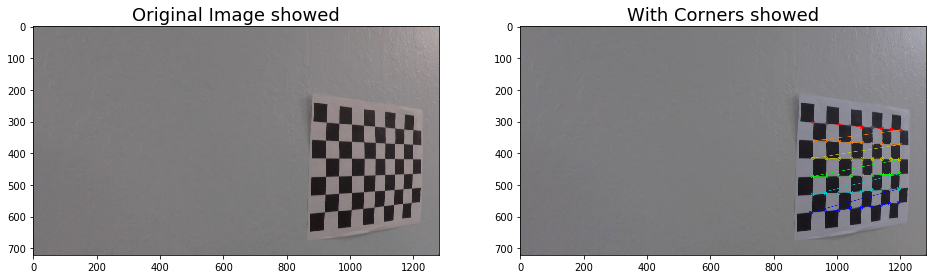

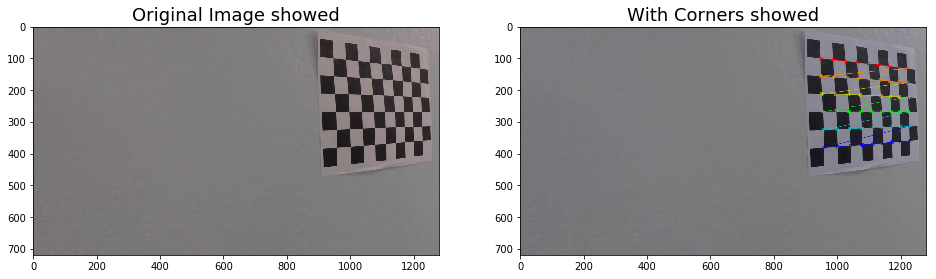

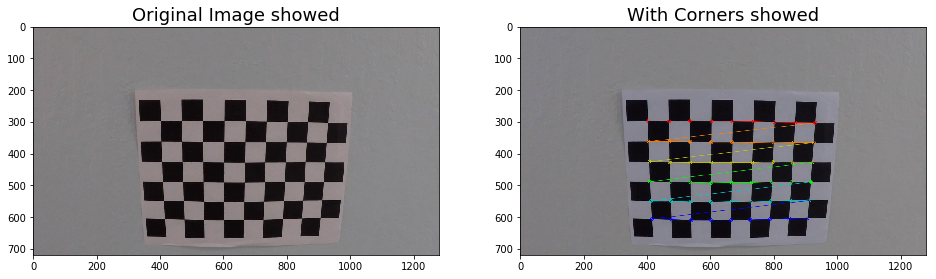

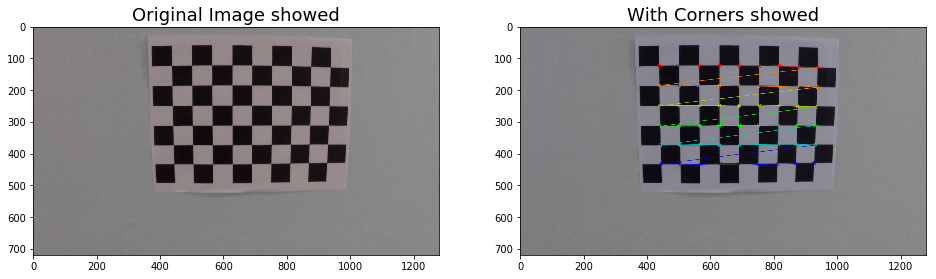

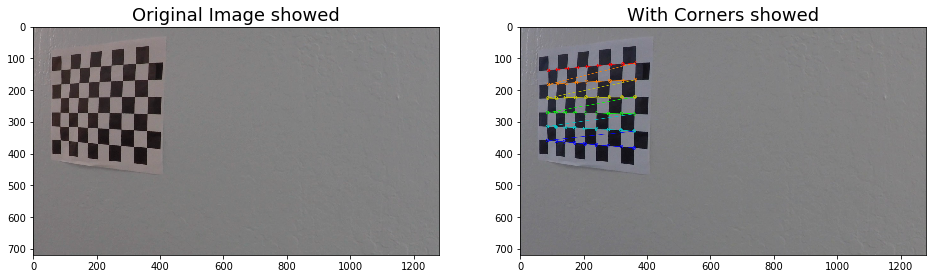

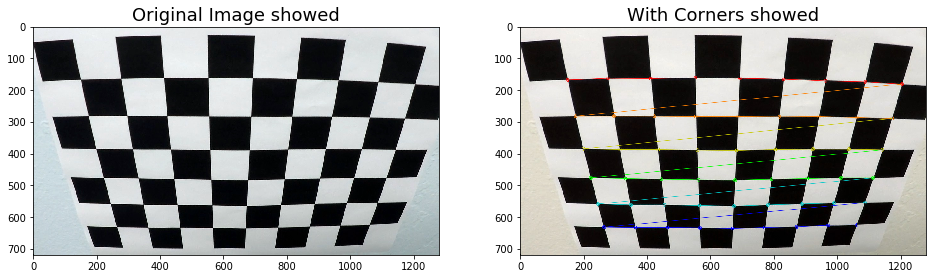

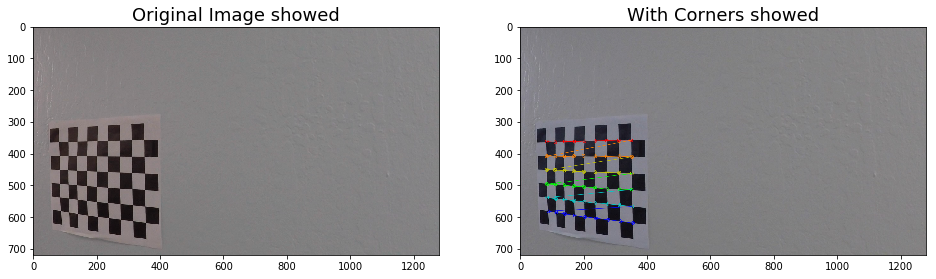

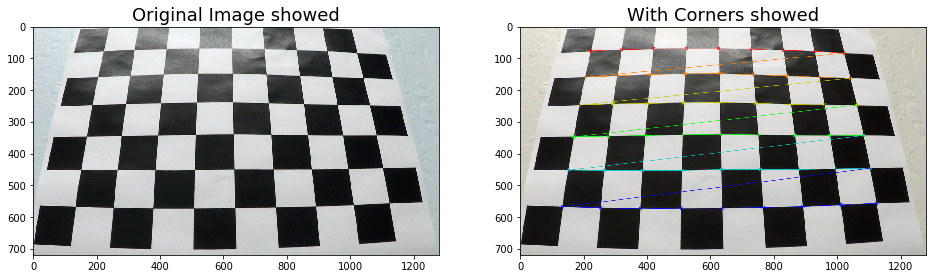

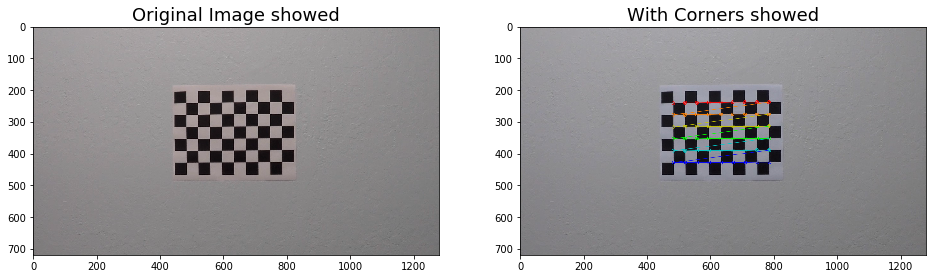

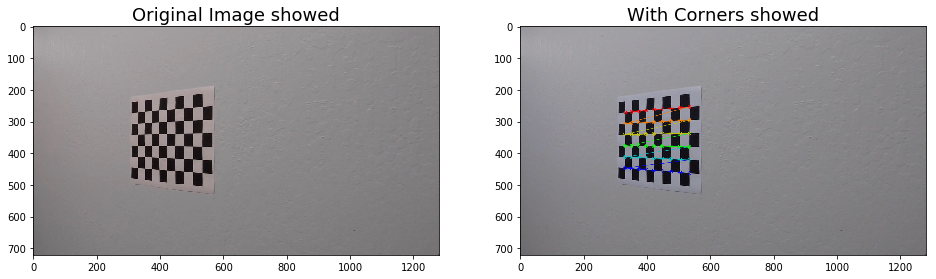

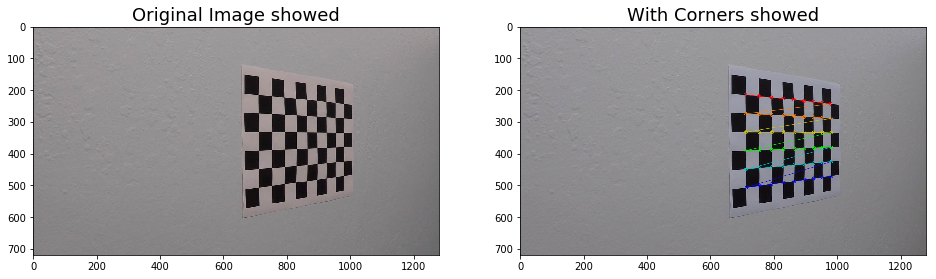

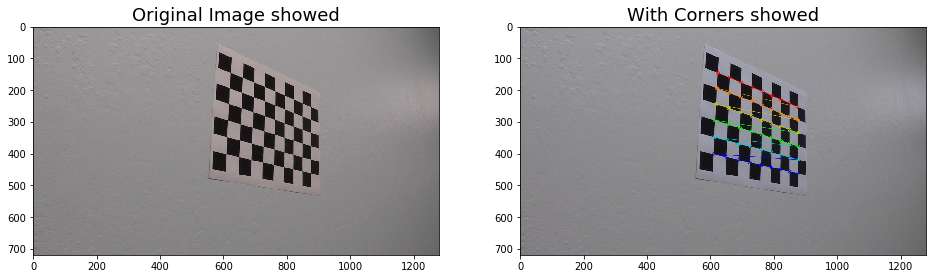

In [2]:
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image showed', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners showed', fontsize=18)

#### 2 Undistortion
Next I will define a function `undistort()` which uses the calculate camera calibration matrix and distortion coefficients to remove distortion from an image and output the undistorted image.

In [3]:
# Remove distortion from images
def undistort(image, show=True, read = False):
    if read:
        image = cv2.imread(image)
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image showed', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image showed', fontsize=20)
    return undist

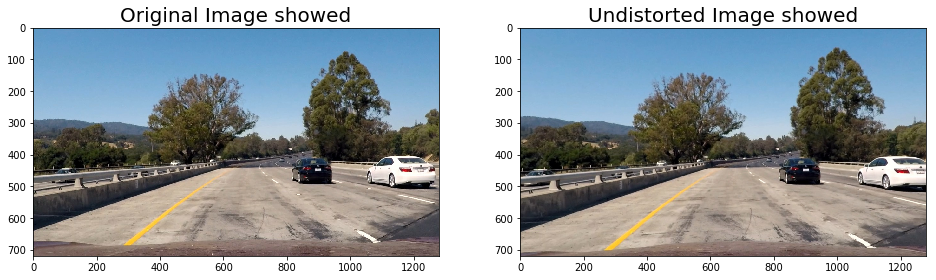

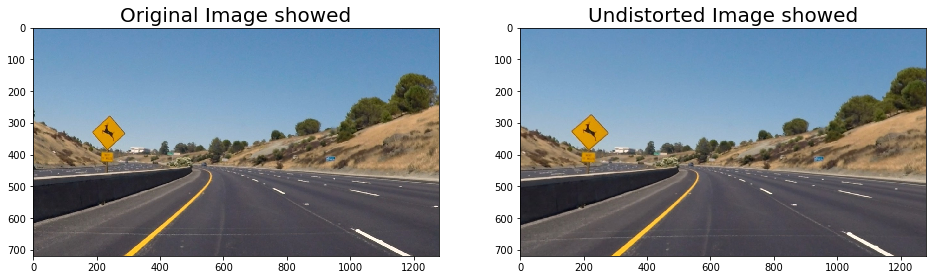

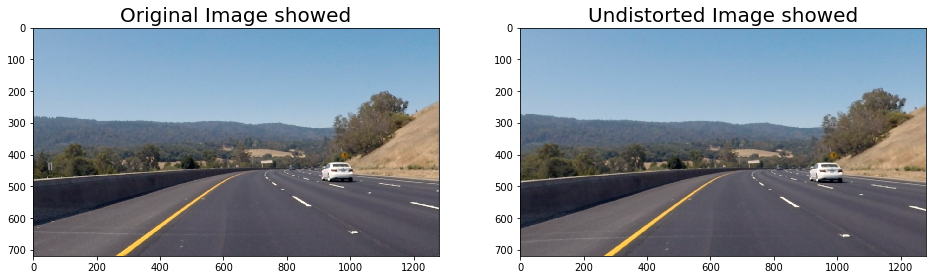

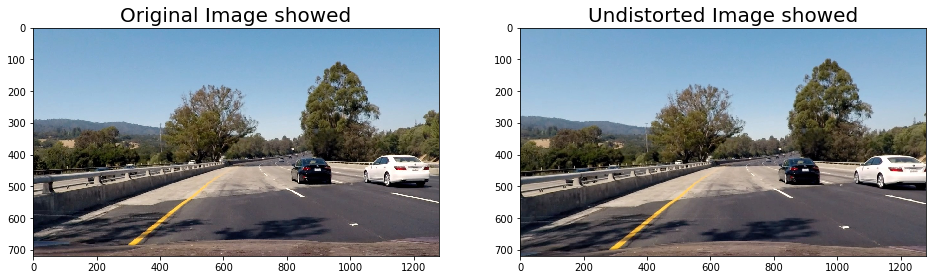

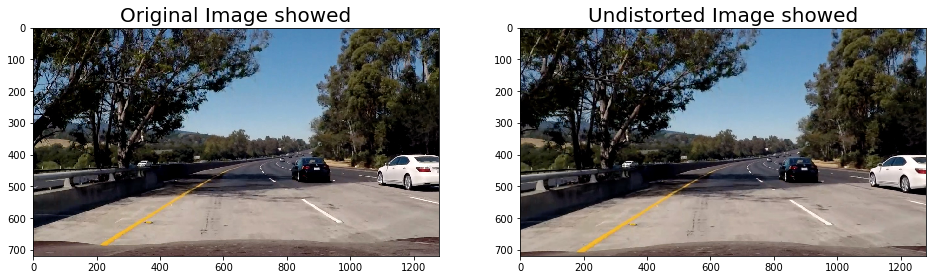

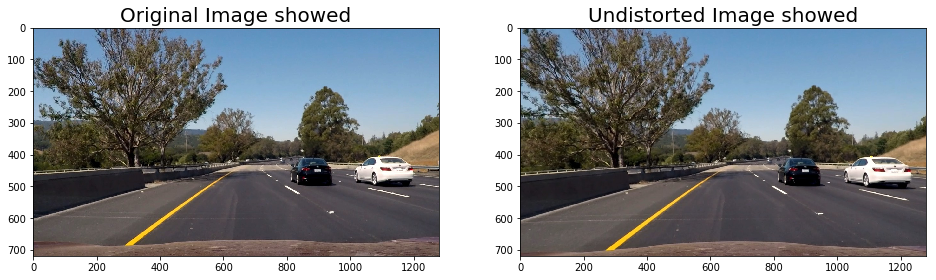

In [4]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image, read = True)

### Step 2: Perspective Transform

In this step I will define a function `birds_eye()` which transforms the undistorted image to a "birds eye view" of the road which focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother. This will make it easier later on to fit polynomials to the lane lines and measure the curvature.

In [5]:
# Perform perspective transform
def birds_eye(img, display = True): 
    h,w = img.shape[:2]

    # define source and destination points for transform
#     src = np.float32([(575,464),
#                       (707,464), 
#                       (258,682), 
#                       (1049,682)])
#     dst = np.float32([(450,0),
#                       (w-450,0),
#                       (450,h),
#                       (w-450,h)])

    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    

    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image showed', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image showed', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M, Minv

In [6]:
for image in glob.glob('test_images/test*.jpg'):
    udisImge = undistort(image, False, read = True)
    warped, M, Minv = birds_eye(udisImge, display = False)
    
    

### Step 3: Apply Binary Thresholds

In this step I attempted to convert the warped image to different color spaces and create binary thresholded images which highlight only the lane lines and ignore everything else. 
I found that the following color channels and thresholds did a good job of identifying the lane lines in the provided test images:
- The S Channel from the HLS color space, with a min threshold of 180 and a max threshold of 255, did a fairly good job of identifying both the white and yellow lane lines, but did not pick up 100% of the pixels in either one, and had a tendency to get distracted by shadows on the road.
- The L Channel from the LUV color space, with a min threshold of 225 and a max threshold of 255, did an almost perfect job of picking up the white lane lines, but completely ignored the yellow lines.
- The B channel from the Lab color space, with a min threshold of 155 and an upper threshold of 200, did a better job than the S channel in identifying the yellow lines, but completely ignored the white lines. 

I chose to create a combined binary threshold based on the three above mentioned binary thresholds, to create one combination thresholded image which does a great job of highlighting almost all of the white and yellow lane lines.

**Note: The S binary threshold was left out of the final combined binary image and was not used in detecting lane lines because it added extra noise to the binary image and interfered with detecting lane lines accurately.**

In [7]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True, read = False):
    if read == True:
        udisImge = undistort(image, False, read = True)
    else:
        udisImge = undistort(image, False)
    img, M, Minv = birds_eye(udisImge, display = False)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
    hls_s = hls_s*(255/np.max(hls_s))
    # 2) Apply a threshold to the L channel
    hls_s_binary = np.zeros_like(hls_s)
    hls_s_binary[(hls_s > 180) & (hls_s <= 255)] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    hls_l_binary = np.zeros_like(hls_l)
    hls_l_binary[(hls_l > 210) & (hls_l <= 255)] = 1
    
    
    # Combine HLS and Lab B channel thresholds
    combined_binary = np.zeros_like(hls_l_binary)
    combined_binary[(hls_l_binary == 1) | (hls_s_binary == 1)] = 1
    

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3,ax4)) = plt.subplots(1, 4,  figsize=(14,5))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(udisImge,cv2.COLOR_BGR2RGB))
        
        ax2.set_title('HLS L binary threshold', fontsize=16)
        ax2.imshow(hls_l_binary, cmap='gray')
        
        ax3.set_title('HLS S binary threshold', fontsize=16)
        ax3.imshow(hls_s_binary, cmap='gray')

        ax4.set_title('Combined color thresholds', fontsize=16)
        ax4.imshow(combined_binary, cmap='gray')
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return combined_binary, Minv

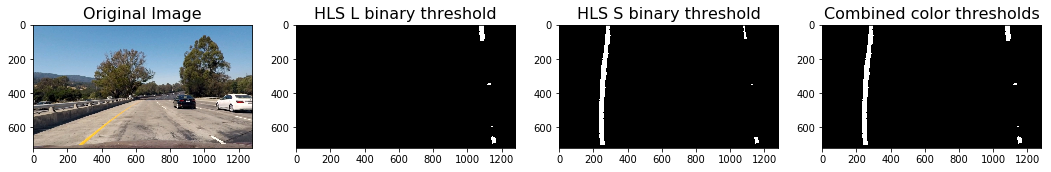

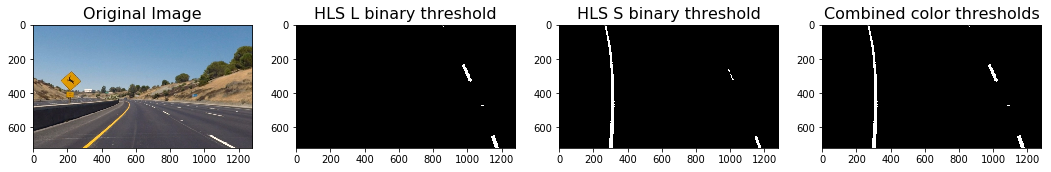

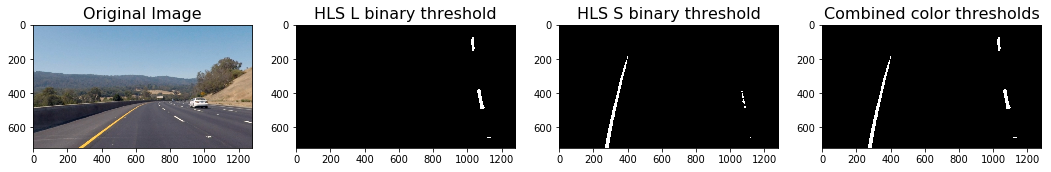

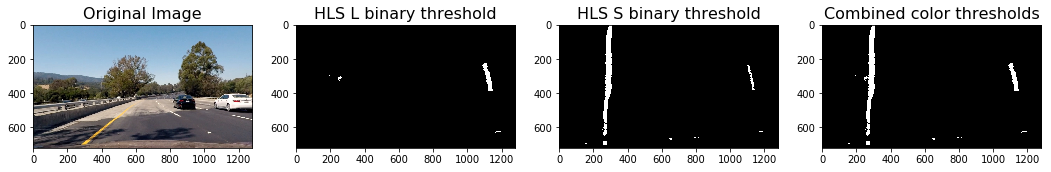

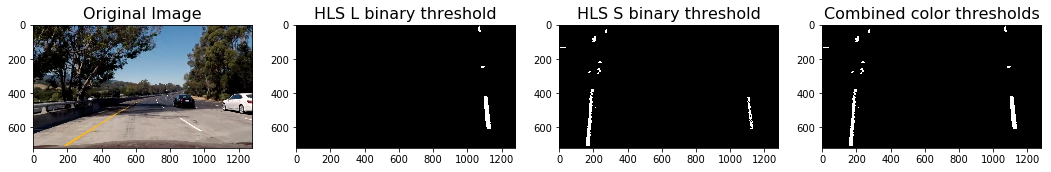

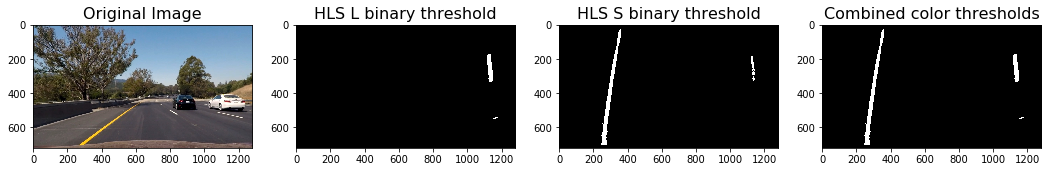

In [8]:
for image in glob.glob('test_images/test*.jpg'):
    apply_thresholds(image,read = True)

### Steps 4, 5 and 6: Fitting a polynomial to the lane lines, calculating vehicle position and radius of curvature:

At this point I was able to use the combined binary image to isolate lane line pixels and fit a polynomial to each of the lane lines. The space in between the identified lane lines is filled in to highlight the driveable area in the lane. The position of the vehicle was measured by taking the average of the x intercepts of each line.

The equation for calculating radius of curvature was discovered at this page: http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In the function `fill_lane()` below, lane lines are detected by identifying peaks in a histogram of the image and detecting nonzero pixels in close proximity to the peaks. 

In [9]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(img))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(img[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90
    
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    
    return left_fit, right_fit, left_curverad, right_curverad, center
# print('...')

(0, 720)

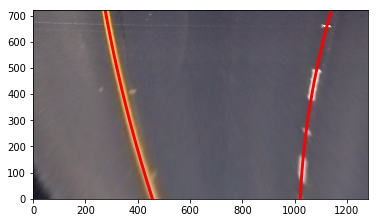

In [10]:
# visualize the result on example image
exampleImg = cv2.imread('./test_images/test3.jpg')
exampleImg_bin, Minv = apply_thresholds(exampleImg, show = False, read = False)
    
left_fit, right_fit, left_curverad, right_curverad, center= sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
# left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
# right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)


# # Create an output image to draw on and  visualize the result
# out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# # Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# for rect in rectangles:
# # Draw the windows on the visualization image
#     cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
#     cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# # Identify the x and y positions of all nonzero pixels in the image
# nonzero = exampleImg_bin.nonzero()
# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

udisImge = undistort('./test_images/test3.jpg', False, read = True)
warped, M, Minv = birds_eye(udisImge, display = False)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.plot(left_fitx, ploty, color='red',linewidth=3)
plt.plot(right_fitx, ploty, color='red',linewidth=3)
plt.xlim(0, 1280)
plt.ylim(0, 720)

### Step 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [11]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

(720, 0)

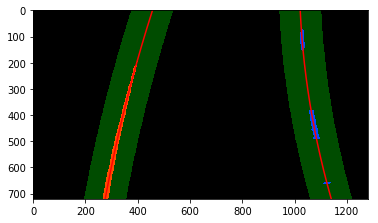

In [12]:
# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test3.jpg')
exampleImg2_bin, Minv = apply_thresholds(exampleImg2,  show = False,  read = False)
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='red')
plt.plot(right_fitx2, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [13]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

...


In [14]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 496.421477851 m, 290.485813694 m
Distance from lane center for example: -0.664632535308 m


In [15]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

...


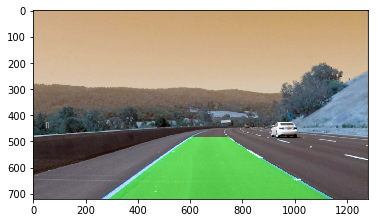

In [16]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)
print('...')

In [17]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

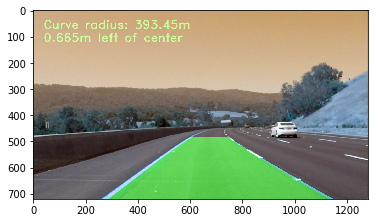

In [18]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)

## Video Processing Pipeline:

First I am going to establish a class Line() for the lines to store attributes about the lane lines from one frame to the next. Inside the class I will define several functions which will be used to detect the pixels belonging to each lane line.

In [19]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

Next I create a function `process_image()` which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.

The video processing pipeline is very similar to the `draw_lane()` function established earlier in the report, except that the video pipeline stores information about the lane lines across frames to average the lane positions and ensure a smooth output which is less impacted by outliers.

The video pipeline also knows whether or not the lane line was detected in the previous frame, and if it was, it only checks for lane pixels in a tight window around the previous polynomial, ensuring a high confidence detection. If the lane line was not detected in the previous frames (and for the first 5 frames of the video) The pipeline performs the same search which was performed in the fill_lanes() function based on identifying peaks in a histogram.

In [20]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = apply_thresholds(new_img,  show = False,  read = False)

    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit,  rad_l, rad_r, d_center = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        l_line.add_fit(l_fit, l_lane_inds)
        r_line.add_fit(r_fit, r_lane_inds)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                           l_lane_inds, r_lane_inds)
        
    
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
#     
    
    # draw the current best fit if it exists
#     if l_line.best_fit is not None and r_line.best_fit is not None:
    img_out1 = draw_lane(new_img, img_bin,  left_fit, right_fit, Minv)
    img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)

#     else:
#         img_out = new_img
    plt.imshow(img_out)

    
#     import sys
#     sys.exit(0)

    return img_out

In [21]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

...


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:01<00:00,  1.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 19min 3s


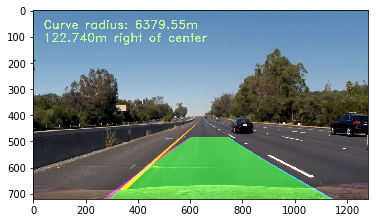

In [29]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

* The following is the result of the video pipeline being run on the project video.

In [31]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


 30%|████████████████████████                                                        | 146/485 [01:58<04:35,  1.23it/s]

TypeError: expected non-empty vector for x

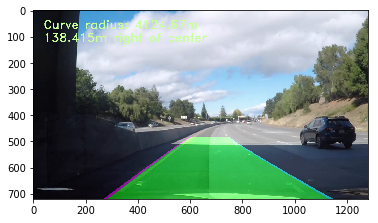

In [23]:
l_line = Line()
r_line = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_image) 
challenge_clip.write_videofile(challenge_output, audio=False)

Next is the result of the pipeline on a harder challenge video

In [54]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))